# Bogota Accessibility: Impact of the TransMiCable Gondola

### Brian Hill, Logan Ritter, Manuel Santana

The goal of this notebook will be to calculate preliminary accessibility estimates for Bogota using the simplified data on employment by Logan Ritter, and the GTFS file by Jarvis Yuan.  

The assumption is that before running this notebook the otp system as outlined in Bogota_OTP_Setup, including the appropriate GTFS, OSM, and Graph objects, as well as Jython, Pandas, Numpy, OSMNX.

### Overview
#### [Section 1: OTP Travel Times & Employment](#section_1)
* [Establish Run Specifications](#run_spec)
* [Make Hexagons](#make_hexagons)
* [Distribute Employment](#distribute_employment)
* [OTP: Aquire Travel Times](#otp_travel_times)

#### [Section 2: Accessibility Analysis](#section_2)
* [Calculate Accessibility](#calculate_acessibility)
* [Data Visualizations](#data_vis)
* [Conclusion](#conclusion)


In [2]:
# Import libraries
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import shutil
import glob
import time
import threading
import os
import tobler
# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import seaborn as sns
import shapely 
from shapely.geometry import Polygon
import mapclassify 
import pysal
import contextily as ctx
# Suppresss warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set path to jython file 
# e.g. /Users/BrianHill/jython2.7.2/bin/jython
jython_path = '/Users/BrianHill/jython2.7.2/bin/jython'

# Set path to otp folder
# Ensure ends in a '/'
# e.g. /Users/BrianHill/otp/
otp_path = '/Users/BrianHill/otp/'

# Change notebook directory to otp_path
os.chdir(otp_path)

# Section 1: OTP Travel Times & Employment

## Establish Run Specifications <a class="anchor" id="run_spec"></a>
The goal is to enable easy customization of input parameters, as well as the ability to store each run's results in a separate folder.

In [4]:
# Location to find city-specific data (e.g. jobs, administrative boundaries)
city_data = r'bogota_data/'

# Location to store run-specific data
run_folder_name = r'bogota_otp_g2'
# We now make this directory
!mkdir {run_folder_name}

# Prefix to add to files from this run 
run_prefix = 'otp_g2_'

# Together
run_path = run_folder_name + '/' + run_prefix
run_path

mkdir: bogota_otp_g2: File exists


'bogota_otp_g2/otp_g2_'

In [5]:
# Hexagon size 
hexagon_diameter = 5000

# Set departure time for travel time calculations
# Format 'year, month, day, hour, minute, second'  (e.g. '2019, 4, 4, 6, 00, 00')
departure_time = '2019, 04, 04, 06, m, 00'

# Set departure minute array to choose from 
departure_minutes = [0,30]

In [6]:
%%bash

cd graphs/bogota_no_gondola
# Router configuration details 
cat > router-config.json
{
  "boardTimes": {
    "BUS": 300
  },
  "routingDefaults": {
    "waitReluctance": 1,
    "waitAtBeginningFactor": 1,
    "walkReluctance": 1,
    "stairsReluctance": 1
  }
}


In [7]:
%%bash
# Copy router configuration to gondola router
cp graphs/bogota_no_gondola/router-config.json graphs/bogota_gondola/router-config.json


## Make Hexagons <a class="anchor" id="make_hexagons"></a>

In this step we cover the city with hexagons of the preset size.

In [8]:

# Get the Bogota city boundaires 
place = {'city': 'Bogota',
         'country':'Colombia'}
bogota_boundary = ox.gdf_from_place(place)
bogota_boundary.crs = {'init':'epsg:4326'}
#bogota_boundary.plot()

# Import ability to draw distances from geodesic (precise)
from geopy.distance import geodesic
#geodesic(origin, dest).km*1000 returns length in meters 

# How large is the city?
xmin, ymin, xmax, ymax = bogota_boundary.total_bounds
# geodesic((latitude,longitude), (latitude, longitude))
dist_long = geodesic((ymin,xmin), (ymin,xmax)).km*1000
print("Longitudinal distance:", dist_long)
dist_lat = geodesic((ymin,xmin), (ymax,xmin)).km*1000
print("Latitudinal distance:", dist_lat)

# Diameter of hexagons 
d = hexagon_diameter

# Horizontal width of hexagon
w = np.sin(np.deg2rad(60))*d

# Approximate size of hexagon grid 
n_cols = int(dist_long/w) +1
print("Approx. number of columns: ", n_cols)
n_rows = int(dist_lat/(3/4 * d)) + 10
print("Approx. number of rows:", n_rows)

# Overlay with equally spaced hexagons

from matplotlib.patches import RegularPolygon

# ax = bogota_boundary.boundary.plot(edgecolor='black',figsize=(20,60))
w = (xmax-xmin)/n_cols # width of hexagon
d = w/np.sin(np.pi/3) #diameter of hexagon
array_of_hexes = []
for rows in range(0,n_rows):
    hcoord = np.arange(xmin,xmax,w) + (rows%2)*w/2
    vcoord = [ymax- rows*d*0.75]*n_cols
    for x, y in zip(hcoord, vcoord):#, colors):
        hexes = RegularPolygon((x, y), numVertices=6, radius=d/2, alpha=0.2, edgecolor='k')
        verts = hexes.get_path().vertices
        trans = hexes.get_patch_transform()
        points = trans.transform(verts)
        array_of_hexes.append(Polygon(points))
        # ax.add_patch(hexes)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#plt.show()

# Extract hexagons inside of the boundary 

hex_grid = gpd.GeoDataFrame({'geometry':array_of_hexes},crs={'init':'epsg:4326'})
bogota_hex = gpd.overlay(hex_grid,bogota_boundary)
bogota_hex = gpd.GeoDataFrame(bogota_hex,geometry='geometry')
#bogota_hex.boundary.plot()

# Strip off unnecesary fields 
bogota_hex.reset_index(inplace=True)
bogota_hex.rename(columns={'index':'HEXID'},inplace=True)
bogota_hex = bogota_hex[['HEXID','geometry']]


Longitudinal distance: 23668.826877335207
Latitudinal distance: 40029.88097027054
Approx. number of columns:  6
Approx. number of rows: 20


In [9]:
bogota_boundary

,geometry,place_name,bbox_north,bbox_south,bbox_east,bbox_west
0,"MULTIPOLYGON (((-74.22351 4.62523, -74.22343 4...","Bogota, Bogota Capital District, 11001, Colombia",4.83317,4.471175,-74.010248,-74.223514


## Distribute Employment <a class="anchor" id="distribute_employment"></a>

Using the jobs data from the 2019 Bogota household travel survey, we calculate the number of trips ending in each TAZ, and then, use tobler to distribute the jobs into each hexagon.  The jobs are distributed proportional to the area of the TAZ in the hexagon.  

In [11]:
# Load the survey data file and calculate number of work destinations in each TAZ
viajes = pd.read_csv(city_data + ("viajes.csv"), sep=';')
ZAT = gpd.read_file((city_data + "ZONAS/ZAT.shp"), sep=';')
viajes_clean = viajes[["id_hogar", "id_persona", "id_viaje", "p17_Id_motivo_viaje", "zat_origen", "zat_destino", "f_exp"]]
#counting the number of trips (either work related or all trips) in each TAZ
#origin is a boolean about whether we want to look at the origin or destination of the trips
#mintrips is used to filter out TAZ's that have a low number of trips to better zoom into the data
def location_counts(origin, only_jobs, min_trips, no_table=False):
    if origin:
        zat_column = "zat_origen"
    else:
        zat_column = "zat_destino"
    if only_jobs:
        viajes_new = viajes[viajes["p17_Id_motivo_viaje"] == 1]
    else:
        viajes_new = viajes
    counts = viajes_new.groupby(zat_column).sum()
    counts.reset_index(level = 0, inplace = True)
    counts["jobs_count"] = counts["f_exp"]
    counts = counts[[zat_column, "jobs_count"]]
    counts = pd.merge(counts, ZAT[["Area", "ZAT", "geometry"]], left_on = zat_column, right_on = "ZAT")
    counts = gpd.GeoDataFrame(counts, geometry=counts["geometry"])
    counts = counts[[zat_column, "jobs_count", "geometry"]]
    counts = counts[counts["jobs_count"] > min_trips]
    if no_table:
        return
    return counts
work_destination_job_count_TAZ = location_counts(False, True, 0)
work_destination_job_count_TAZ

,zat_destino,jobs_count,geometry
0,1.0,308.737618,"POLYGON Z ((-74.06383 4.77235 0.00000, -74.063..."
1,2.0,107.002656,"POLYGON Z ((-74.05306 4.82550 0.00000, -74.053..."
2,3.0,311.561784,"POLYGON Z ((-74.03007 4.82343 0.00000, -74.029..."
3,4.0,700.972891,"POLYGON Z ((-74.04066 4.78609 0.00000, -74.040..."
4,7.0,1622.454159,"POLYGON Z ((-74.04154 4.77941 0.00000, -74.040..."
...,...,...,...
1013,1903.0,2650.408680,"POLYGON Z ((-73.95672 4.94255 0.00000, -73.955..."
1014,1904.0,92.772562,"POLYGON Z ((-73.86543 5.00181 0.00000, -73.847..."
1015,1905.0,4437.804867,"POLYGON Z ((-73.94001 4.93084 0.00000, -73.940..."
1016,1906.0,587.320839,"POLYGON Z ((-73.98746 5.04507 0.00000, -73.986..."


In [12]:
bogota_hex

,HEXID,geometry
0,0,"POLYGON ((-74.06502 4.82207, -74.07879 4.81412..."
1,1,"POLYGON ((-74.02802 4.82333, -74.02802 4.82291..."
2,2,"MULTIPOLYGON (((-74.05793 4.81966, -74.04579 4..."
3,3,"POLYGON ((-74.02802 4.82291, -74.02635 4.82194..."
4,4,"POLYGON ((-74.09911 4.76138, -74.09911 4.76134..."
5,5,"MULTIPOLYGON (((-74.06356 4.77131, -74.06356 4..."
6,6,"POLYGON ((-74.04579 4.79213, -74.02802 4.78187..."
7,7,"POLYGON ((-74.12207 4.75408, -74.11688 4.75108..."
8,8,"POLYGON ((-74.09911 4.76134, -74.08134 4.75108..."
9,9,"POLYGON ((-74.06356 4.76134, -74.04579 4.75108..."


In [14]:
work_destination_job_count_TAZ

,zat_destino,jobs_count,geometry
0,1.0,308.737618,"POLYGON Z ((-74.06383 4.77235 0.00000, -74.063..."
1,2.0,107.002656,"POLYGON Z ((-74.05306 4.82550 0.00000, -74.053..."
2,3.0,311.561784,"POLYGON Z ((-74.03007 4.82343 0.00000, -74.029..."
3,4.0,700.972891,"POLYGON Z ((-74.04066 4.78609 0.00000, -74.040..."
4,7.0,1622.454159,"POLYGON Z ((-74.04154 4.77941 0.00000, -74.040..."
...,...,...,...
1013,1903.0,2650.408680,"POLYGON Z ((-73.95672 4.94255 0.00000, -73.955..."
1014,1904.0,92.772562,"POLYGON Z ((-73.86543 5.00181 0.00000, -73.847..."
1015,1905.0,4437.804867,"POLYGON Z ((-73.94001 4.93084 0.00000, -73.940..."
1016,1906.0,587.320839,"POLYGON Z ((-73.98746 5.04507 0.00000, -73.986..."


In [13]:
# Ensure both dataframes have same CRS
work_destination_job_count_TAZ.crs = {'init':'epsg:4686'}
bogota_hex.crs = {'init':"epsg:4686"}
# TOBLER: Weight hexagon job counts by weighted average of TAZ job counts
bogota_hex_jobs = tobler.area_weighted.area_interpolate(source_df=work_destination_job_count_TAZ, target_df=bogota_hex, extensive_variables=["jobs_count"])
bogota_hex_jobs.reset_index(inplace=True)
bogota_hex_jobs.rename(columns={'index':'HEXID'},inplace=True)
bogota_hex_jobs.to_file((run_path + 'bogota_hex_jobs.shp'))
bogota_hex_jobs


,HEXID,jobs_count,geometry
0,0,303.151783,"POLYGON ((-74.06502 4.82207, -74.07879 4.81412..."
1,1,12094.946722,"POLYGON ((-74.02802 4.82333, -74.02802 4.82291..."
2,2,2659.977959,"MULTIPOLYGON (((-74.05793 4.81966, -74.04579 4..."
3,3,5162.184299,"POLYGON ((-74.02802 4.82291, -74.02635 4.82194..."
4,4,10044.188415,"POLYGON ((-74.09911 4.76138, -74.09911 4.76134..."
5,5,5198.365092,"MULTIPOLYGON (((-74.06356 4.77131, -74.06356 4..."
6,6,31184.439325,"POLYGON ((-74.04579 4.79213, -74.02802 4.78187..."
7,7,21752.499842,"POLYGON ((-74.12207 4.75408, -74.11688 4.75108..."
8,8,57534.440258,"POLYGON ((-74.09911 4.76134, -74.08134 4.75108..."
9,9,49048.631772,"POLYGON ((-74.06356 4.76134, -74.04579 4.75108..."


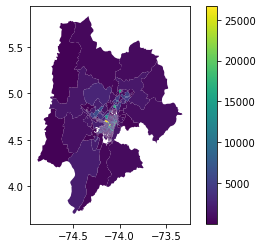

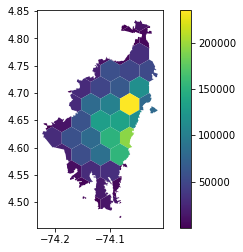

In [25]:
# Rough plot of trip endings by TAZ
work_destination_job_count_TAZ.plot(column='jobs_count', legend=True)
# Rough plot of jobs distribution by hexagon
bogota_hex_jobs.plot(column='jobs_count', legend=True)

## OTP: Aquire Travel Times <a class="anchor" id="otp_travel_time"></a>

A great thanks to Rafael Pereria for providing the base code for this section in his 

We will be running analysis on the overall accessibility with and without the gondola for all of bogota using the hexagons.  

Also here we consider changing the python script to make it more managable to do calculations on them, to calculate the accessibility mid-way through instead of at the end.  Also, the code has been properly threaded and currently saves multiple csvs instead of just one big one to avoid memory errors.

Further, for speed improvements the code has been parallized.


In [26]:
# Add in longitude and latitude of the centroid of each hexagon to prepare for Open Trip Planner Processing
bogota_hex_point_jobs = gpd.GeoDataFrame(bogota_hex_jobs)
bogota_hex_point_jobs['centroid'] = bogota_hex_point_jobs.centroid
bogota_hex_point_jobs.set_geometry('centroid', inplace=True)
bogota_hex_point_jobs['longitude'] = bogota_hex_point_jobs.geometry.x
bogota_hex_point_jobs['latitude'] = bogota_hex_point_jobs.geometry.y

# Save as simple csv to be accessed by processing script later
bogota_hex_point_jobs[['HEXID','longitude','latitude']].to_csv((run_path + 'bogota_hex_jobs.csv'))

bogota_hex_point_jobs

,HEXID,jobs_count,geometry,centroid,longitude,latitude
0,0,303.151783,"POLYGON ((-74.06502 4.82207, -74.07879 4.81412...",POINT (-74.07365 4.82034),-74.073652,4.820345
1,1,12094.873185,"POLYGON ((-74.02802 4.82333, -74.02802 4.82291...",POINT (-74.04469 4.82262),-74.044688,4.822620
2,2,2660.098268,"MULTIPOLYGON (((-74.05793 4.81966, -74.04579 4...",POINT (-74.05770 4.80795),-74.057698,4.807952
3,3,5162.137447,"POLYGON ((-74.02802 4.82291, -74.02635 4.82194...",POINT (-74.03604 4.80253),-74.036042,4.802530
4,4,10044.188415,"POLYGON ((-74.09911 4.76138, -74.09911 4.76134...",POINT (-74.11231 4.75817),-74.112315,4.758169
5,5,5198.575816,"MULTIPOLYGON (((-74.06356 4.77131, -74.06356 4...",POINT (-74.07565 4.75941),-74.075651,4.759408
6,6,31184.228590,"POLYGON ((-74.04579 4.79213, -74.02802 4.78187...",POINT (-74.04534 4.77137),-74.045336,4.771369
7,7,21752.499842,"POLYGON ((-74.12207 4.75408, -74.11688 4.75108...",POINT (-74.12645 4.73600),-74.126447,4.736003
8,8,57534.440258,"POLYGON ((-74.09911 4.76134, -74.08134 4.75108...",POINT (-74.09911 4.74082),-74.099109,4.740823
9,9,49048.631772,"POLYGON ((-74.06356 4.76134, -74.04579 4.75108...",POINT (-74.06356 4.74082),-74.063565,4.740823


#### Create Script

Here we use the %%bash command to use terminal to write the travel time calculating script.  Note that we have included the customizable run_path variable in two ways.  First, we passed it into the first line using 's- {run_path}' then refrencing it as ${1}.  Second, we used set to, somewhat less elegantly, 'replace to_be_filled_run_path' with our run_path variable. 

We also replace 'to_be_filled_departure_time' with our departure_time variable. 

In [39]:
%%bash -s {run_path}
cat > "${1}parallel_no_gondola.py"

import time
import threading
import shutil
import glob

# Various Input files and settings
router = 'bogota_no_gondola'
my_run_path = 'to_be_filled_run_path'
my_otp_path = 'to_be_filled_otp_path'
points_file = my_run_path + 'bogota_hex_jobs.csv'
dest_file = points_file
departure_minutes = to_be_filled_departure_minutes
departure_time = 'to_be_filled_departure_time'

max_threads = 4
# SOURCE: RAFAEL PERERIA, python_script
from org.opentripplanner.scripting.api import OtpsEntryPoint
# Instantiate an OtpsEntryPoint
# NOTE WOULD NEED TO CHANGE THIS IN ORDER TO 
otp = OtpsEntryPoint.fromArgs(['--graphs', '/Users/BrianHill/otp/graphs',
                               '--router', router])

# Start timing the code
start_time = time.time()

# Get the default router
router = otp.getRouter(router)
                               
for m in departure_minutes:
    minute = str(m).zfill(2)
    #exact_departure_time = r'to_be_filled_departure_time' % minute 
    #set different output file for each time
    output_file = my_run_path + minute + '_parallel_no_gondola.csv'
    # Create a default request for a given departure time
    req = otp.createRequest()
    req.setDateTime(to_be_filled_departure_time)  # set departure time
    req.setModes('WALK,BUS,RAIL,TRANSIT')         # define transport mode
    req.setClampInitialWait(0)

    points = otp.loadCSVPopulation(points_file, 'latitude', 'longitude')
    dests = otp.loadCSVPopulation(dest_file, 'latitude', 'longitude')
    
    def do_the_stuff(h,i, origin, req):
        # Create a CSV output
        matrixCsv = otp.createCSVOutput()
        #matrixCsv.setHeader([ 'year','depart_time', 'origin', 'destination', 'walk_distance', 'travel_time' ])
        #print("Processing origin: ", str(h)+"-"+str(0)," ", origin.getStringData('GEOID'), 'on ',threading.current_thread())
        req.setOrigin(origin)
        spt = router.plan(req)
        if spt is None: return
        # Evaluate the SPT for all points
        result = spt.eval(dests)
        # Add a new row of result in the CSV output
        for r in result:
           matrixCsv.addRow([ origin.getStringData('HEXID'), r.getIndividual().getStringData('HEXID'), r.getWalkDistance() , r.getTime(),  r.getBoardings() ])
        # Save the result
        csv_name = my_run_path + 'zarb_unique_' + minute + 'no_gondola_origin' + str(origin.getStringData('HEXID')) + '.csv'
        matrixCsv.save(csv_name)
        print(csv_name)
        print("Time since start was %g seconds" % (time.time() - start_time))
    
    
    # start looping over jobs
    i = 1
    origins = []
    for origin in points:
        origins.append(origin)
    while i < len(origins) + 1:
        if threading.active_count() < max_threads + 1:
            origin = origins[i - 1]
            thread = threading.Thread(target=do_the_stuff,args=(6,i, origin, req))
            thread.start()
            #thread.daemon = True        
            i += 1
        else:
            time.sleep(0.1)
    # now wait for all daemon threads to end before letting
    # the main thread die. Otherwise stuff will get cut off
    # before it's finished
    while threading.active_count() > 1:
        time.sleep(0.1)
    print('ALL JOBS COMPLETED! Concatenating files')
    
    
    #import csv files from folder
    path = my_otp_path + my_run_path
    allFiles = glob.glob(path + 'zarb_unique_' + minute + 'no_gondola_origin*.csv')
    allFiles.sort()  # glob lacks reliable ordering, so impose your own if output order matters
    with open(output_file, 'wb') as outfile:
        for i, fname in enumerate(allFiles):
            with open(fname, 'rb') as infile:
                if True:
                    infile.readline()  # Read all lines
                # Block copy rest of file from input to output without parsing
                shutil.copyfileobj(infile, outfile)
                print(fname + " has been imported.")

    print("Done with minute %s" % minute)
                
print("Elapsed time was %g seconds" % (time.time() - start_time))

In [40]:
# Fill in departure time with stored departure_time variable
!sed -i '' "s#to_be_filled_departure_time#{departure_time}#" {run_path}parallel_no_gondola.py
# Fill in to_be_filled_minutes with stored run_path variable 
!sed -i '' "s#to_be_filled_departure_minutes#{departure_minutes}#" {run_path}parallel_no_gondola.py
# Fill in to_be_filled_run_path with stored run_path variable 
!sed -i '' "s#to_be_filled_run_path#{run_path}#" {run_path}parallel_no_gondola.py
# Fill in to_be_filled_otp_path with otp path
!sed -i '' "s#to_be_filled_otp_path#{otp_path}#" {run_path}parallel_no_gondola.py

We also make the gondola script by replacing every instance of no_gondola with gondola, thus refrencing the gondola router instead of the no_gondola router, and saving file names appropriately.

In [43]:
# Make gondola script
!sed 's/no_gondola/gondola/' {run_path}parallel_no_gondola.py > {run_path}parallel_gondola.py


### Run Travel Time Calculations

#### No Gondola

In [42]:
# Run the python script on the java OTP jar using jython
!{jython_path} -J-XX:-UseGCOverheadLimit -J-Xmx10G -Dpython.path=otp-1.4.0-shaded.jar {run_path}parallel_no_gondola.py
!say done processing no gondola nodes


00:44:51.008 INFO (OTPServer.java:39) Wiring up and configuring server.
00:44:51.200 INFO (GraphScanner.java:64) Attempting to automatically register routerIds [bogota_no_gondola]
00:44:51.200 INFO (GraphScanner.java:65) Graph files will be sought in paths relative to /Users/BrianHill/otp/graphs
00:44:51.205 INFO (GraphService.java:176) Registering new router 'bogota_no_gondola'
00:44:51.206 INFO (InputStreamGraphSource.java:181) Loading graph...
00:44:51.762 INFO (Graph.java:746) Graph version: MavenVersion(1, 4, 0, , b272f14007c97d769216e9ebab65baad7410cdf5)
00:44:51.762 INFO (Graph.java:747) OTP version:   MavenVersion(1, 4, 0, , b272f14007c97d769216e9ebab65baad7410cdf5)
00:44:51.763 INFO (Graph.java:764) This graph was built with the currently running version and commit of OTP.
00:45:01.726 INFO (Graph.java:731) Main graph read. |V|=238654 |E|=1275454
hsqldb.db.HSQLDB4AD417742A.ENGINE INFO dataFileCache open start
00:45:05.666 INFO (GraphIndex.java:127) Indexing graph...
00:45:07.4

ba_5000m/hex5000_zarb_unique_30no_gondola_origin3.csv
ba_5000m/hex5000_zarb_unique_30no_gondola_origin0.csv
Time since start was 209.87 seconds
Time since start was 209.87 seconds
ba_5000m/hex5000_zarb_unique_30no_gondola_origin1.csv
Time since start was 209.877 seconds
00:48:41.474 ERROR (Graph.java:238) duplicate vertex label in graph (added vertex to graph anyway): <sample-46 lat,lng=4.771369356915072,-74.04533583108986>
ba_5000m/hex5000_zarb_unique_30no_gondola_origin4.csv
Time since start was 210.372 seconds
ba_5000m/hex5000_zarb_unique_30no_gondola_origin5.csv
Time since start was 219.002 seconds
ba_5000m/hex5000_zarb_unique_30no_gondola_origin6.csv
Time since start was 219.167 seconds
ba_5000m/hex5000_zarb_unique_30no_gondola_origin7.csv
Time since start was 226.762 seconds
ba_5000m/hex5000_zarb_unique_30no_gondola_origin8.csv
Time since start was 236.454 seconds
ba_5000m/hex5000_zarb_unique_30no_gondola_origin9.csv
Time since start was 247.972 seconds
ba_5000m/hex5000_zarb_uniq

In [36]:
# Remove all of the intermediary files
!rm {run_path}*zarb_unique*

#### Gondola

In [44]:
# Repeat for gondola scenario
!{jython_path} -J-XX:-UseGCOverheadLimit -J-Xmx10G -Dpython.path=otp-1.4.0-shaded.jar {run_path}parallel_gondola.py
!say done processing gondola nodes


00:55:50.504 INFO (OTPServer.java:39) Wiring up and configuring server.
00:55:50.701 INFO (GraphScanner.java:64) Attempting to automatically register routerIds [bogota_gondola]
00:55:50.701 INFO (GraphScanner.java:65) Graph files will be sought in paths relative to /Users/BrianHill/otp/graphs
00:55:50.712 INFO (GraphService.java:176) Registering new router 'bogota_gondola'
00:55:50.712 INFO (InputStreamGraphSource.java:181) Loading graph...
00:55:51.196 INFO (Graph.java:746) Graph version: MavenVersion(1, 4, 0, , b272f14007c97d769216e9ebab65baad7410cdf5)
00:55:51.197 INFO (Graph.java:747) OTP version:   MavenVersion(1, 4, 0, , b272f14007c97d769216e9ebab65baad7410cdf5)
00:55:51.197 INFO (Graph.java:764) This graph was built with the currently running version and commit of OTP.
00:56:02.770 INFO (Graph.java:731) Main graph read. |V|=241656 |E|=1282226
hsqldb.db.HSQLDB4AD417742A.ENGINE INFO dataFileCache open start
00:56:07.142 INFO (GraphIndex.java:127) Indexing graph...
00:56:08.881 INF

/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_00gondola_origin29.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_00gondola_origin3.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_00gondola_origin30.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_00gondola_origin31.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_00gondola_origin32.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_00gondola_origin33.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_00gondola_origin34.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_00gondola_origin35.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_00gondola_origin36.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_00gondola_origin37.csv has been imported.
/Users/BrianHill/otp/ba_5000m/hex5000_zarb_unique_00gondola_origin38.csv has been

In [38]:
# Remove all of the intermediary files
!rm {run_path}*zarb_unique*

# Section 2: Acessibility Analysis <a class="anchor" id="section_2"></a>

## Calculate Accessibility  <a class="anchor" id="calculate_acessibility"></a>

Now we have created the hexagons, jobs and travel times data.  All of these datasets are saved locally in the run folder.  If the notebook has been run before, it is possible to restart from here and load in the data.  It is also possible to load in the data of another previous run to analyze. 

We will first specify which run we want to work with, and process to get acessibilities at various thresholds.


In [3]:
# INPUT FILES 
# Specify the folder and prefix to look for run results

# Set path to otp folder
# Ensure ends in a '/'
# e.g. /Users/BrianHill/otp/
otp_path = '/Users/BrianHill/otp/'  #<-------INPUT

# Change notebook directory to otp_path
os.chdir(otp_path)

# Location to find city-specific data (e.g. jobs, administrative boundaries)
# Ensure ends in '/', e.g. 'bogota_data/'
city_data = 'bogota_data/'         #<------INPUT

# Location to store run-specific data
run_folder_name = r'ba_400m'      #<------INPUT

# Prefix to add to files from this run 
run_prefix = 'hex400_2020_07_30_'            #<------INPUT

# Together
run_path = run_folder_name + '/' + run_prefix


In [4]:
# Specify which minutes to look at
departure_minutes = [0, 30]
minute = str(departure_minutes[0]).zfill(2)

# This sets the specified values to the appropriate names
gondola_csv = run_path  + minute + '_parallel_gondola.csv'
no_gondola_csv = run_path + minute + '_parallel_no_gondola.csv'
bogota_hex_jobs_shp = run_path + 'bogota_hex_jobs.shp'

In [11]:
bogota_hex_jobs = gpd.read_file(bogota_hex_jobs_shp)
centr = bogota_hex_jobs.centroid
bogota_hex_jobs['lon'] = centr.x
bogota_hex_jobs['lat'] = centr.y
bogota_hex_jobs['id'] = bogota_hex_jobs['HEXID']

bogota_hex_jobs.to_file('bogota_hex_jobs.geojson',driver='GeoJSON')
bogota_hex_jobs

,HEXID,jobs_count,geometry,lon,lat,id
0,0,23.921741,"POLYGON ((-74.08050 4.83566, -74.08134 4.83517...",-74.081111,4.835380,0
1,1,171.510487,"POLYGON ((-74.07670 4.83682, -74.07670 4.83606...",-74.077945,4.835990,1
2,2,226.797366,"POLYGON ((-74.07361 4.83631, -74.07361 4.83606...",-74.075259,4.836202,2
3,3,37.826245,"POLYGON ((-74.07274 4.83556, -74.07361 4.83606...",-74.073303,4.835981,3
4,4,23.705130,"POLYGON ((-74.06539 4.83546, -74.06588 4.83517...",-74.065809,4.835366,4
...,...,...,...,...,...,...
4579,4579,38.228012,"POLYGON ((-74.07927 4.47412, -74.07979 4.47382...",-74.079869,4.474459,4579
4580,4580,2.694928,"POLYGON ((-74.08288 4.47310, -74.08288 4.47265...",-74.082975,4.472896,4580
4581,4581,220.973221,"POLYGON ((-74.08065 4.47431, -74.07979 4.47382...",-74.081065,4.472792,4581
4582,4582,52.662294,"POLYGON ((-74.07958 4.47191, -74.07979 4.47203...",-74.079399,4.473085,4582


In [14]:
travel_times_all

,origin,destination,travel_time_min_no_gondola,travel_time_min_gondola
0,10,5,46.716667,46.716667
1,10,7,36.233333,36.233333
2,10,8,36.183333,36.183333
3,10,10,12.300000,12.300000
4,10,11,11.350000,11.350000
...,...,...,...,...
20142241,999,4579,154.016667,154.016667
20142242,999,4580,150.933333,150.933333
20142243,999,4581,151.133333,151.133333
20142244,999,4582,153.683333,153.683333


In [13]:
bogota_hex_jobs = gpd.read_file(bogota_hex_jobs_shp)

cutoff_times = [0,10,15,20,30,40,45,50,60,70,75,80,90,100,115,110,120]

# PROCESSING TO GET ACCESSIBILITIES
travel_time_no_gondola = pd.read_csv(no_gondola_csv, header=None)
#display(travel_time_no_gondola)
travel_time_no_gondola.columns = [ 'origin', 'destination', 'walk_distance', 'travel_time', 'boardings' ]
travel_time_no_gondola['travel_time_min'] = travel_time_no_gondola['travel_time']/60
travel_time_no_gondola.drop(columns=['walk_distance','boardings','travel_time'], inplace=True)

travel_time_gondola = pd.read_csv(gondola_csv, header=None)
#display(travel_time_gondola)
travel_time_gondola.columns = [ 'origin', 'destination', 'walk_distance', 'travel_time', 'boardings' ]
travel_time_gondola['travel_time_min'] = travel_time_gondola['travel_time']/60
travel_time_gondola.drop(columns=['walk_distance','boardings', 'travel_time'], inplace=True)
#travel_time_gondola

# Combine results 
travel_times_all = pd.merge(travel_time_no_gondola, travel_time_gondola, on = ['origin', 'destination'], suffixes=('_no_gondola','_gondola'))
#travel_times_all['change_time_min'] = travel_times_all['travel_time_min_no_gondola'] - travel_times_all['travel_time_min_gondola']

# Merge in destinations jobs data
geo_travel_times_all = pd.merge(travel_times_all, bogota_hex_jobs[['HEXID','jobs_count']], how= 'left', left_on='destination', right_on='HEXID')
geo_travel_times_all.rename(columns={'jobs_count':'jobs_count_destination'}, inplace=True)
geo_travel_times_all.drop(columns='HEXID', inplace=True)
#geo_travel_times_all


# Calculate accessibilities 
bogota_hex_access_no_gondola = bogota_hex_jobs[['HEXID', 'geometry']]
bogota_hex_access_gondola = bogota_hex_jobs[['HEXID','geometry']]

for cutoff in cutoff_times :
    
    access_no_gondola = geo_travel_times_all[(geo_travel_times_all['travel_time_min_no_gondola'] < cutoff)].groupby('origin').agg(np.sum)[['jobs_count_destination']]
    access_no_gondola.rename(columns={'jobs_count_destination':cutoff}, inplace=True)
    bogota_hex_access_no_gondola = pd.merge(left=bogota_hex_access_no_gondola, right=access_no_gondola, left_on='HEXID', right_index=True, how='left')
    
    access_gondola = geo_travel_times_all[(geo_travel_times_all['travel_time_min_gondola'] < cutoff)].groupby('origin').agg(np.sum)[['jobs_count_destination']]
    access_gondola.rename(columns={'jobs_count_destination':cutoff}, inplace=True)
    bogota_hex_access_gondola = pd.merge(left=bogota_hex_access_gondola, right=access_gondola, left_on='HEXID', right_index=True, how='left')

# Fill na values 
bogota_hex_access_no_gondola.fillna(0, inplace=True)
bogota_hex_access_gondola.fillna(0, inplace=True)

display(bogota_hex_access_no_gondola.head(10))



,HEXID,geometry,0,10,15,20,30,40,45,50,60,70,75,80,90,100,115,110,120
0,0,"POLYGON ((-74.08050 4.83566, -74.08134 4.83517...",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,"POLYGON ((-74.07670 4.83682, -74.07670 4.83606...",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,"POLYGON ((-74.07361 4.83631, -74.07361 4.83606...",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,"POLYGON ((-74.07274 4.83556, -74.07361 4.83606...",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,"POLYGON ((-74.06539 4.83546, -74.06588 4.83517...",0.0,205.153123,349.759359,376.507042,533.314183,773.602802,1153.510787,1530.094407,2509.510510,4797.243068,5772.325205,12103.871809,15653.891875,41805.643048,137651.283812,93010.220351,205151.790980
5,5,"POLYGON ((-74.06273 4.83521, -74.06279 4.83517...",0.0,177.240448,282.511204,356.457891,528.454011,621.995408,952.221957,1447.962534,2395.029241,3789.499947,5550.672240,11816.289734,14942.351284,22184.526815,84442.412568,53304.823554,127992.873472
6,6,"POLYGON ((-74.08443 4.83351, -74.08443 4.83339...",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,7,"POLYGON ((-74.08149 4.83526, -74.08134 4.83517...",0.0,11.617435,513.012428,516.532244,661.219476,1263.006613,1691.971421,1998.526622,2755.836889,3241.268282,3866.182079,4999.124430,6929.726946,16612.997496,46816.338047,24727.821175,72301.915515
8,8,"POLYGON ((-74.07961 4.83596, -74.07825 4.83517...",0.0,11.617435,513.012428,516.532244,740.543738,1263.006613,1691.971421,1998.526622,2759.297813,3241.268282,3866.182079,4999.124430,6929.726946,16618.097487,46816.338047,24727.821175,72301.915515
9,9,"POLYGON ((-74.07670 4.83606, -74.07516 4.83517...",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Save data to external file for other analyses.
The columns are labeled as so: 

50_ng --> Accessibility at 50 minute cutoff with no gondola

10_g --> Accessibility at 10 minute cutoff with gondola

30_c --> 30_g - 30_ng, Change in acessibility at 30 minute threshold

30_cp --> (30_g - 30_ng)/30_ng, Percent change in acessibility at 30 minute threshold

geometry --> (multi)polygon denoting hexagon area

cutoff_times = [0,10,15,20,30,40,45,50,60,70,75,80,90,100,115,110,120]

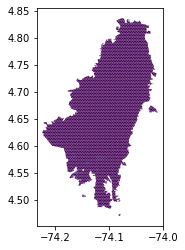

In [98]:
acessibility_data = pd.merge(bogota_hex_access_no_gondola, bogota_hex_access_gondola, on=['HEXID','geometry'], suffixes = ('_ng','_g'))
for time in cutoff_times :
    data_g = str(time) +'_g'
    data_ng = str(time) + '_ng'
    acessibility_data[str(time) + '_c'] = acessibility_data[data_g] - acessibility_data[data_ng]
    acessibility_data[str(time) + '_cp'] = 100*(acessibility_data[data_g] - acessibility_data[data_ng])/acessibility_data[data_ng]
    acessibility_data.fillna(0,inplace=True)

acessibility_data.to_file(run_path + 'accessibility_data'+'.geojson', driver="GeoJSON")

acessibility_data.plot(column='30_c')
# acessibility_data_60_clean = acessibility_data.drop(index=[243,15,4052], axis=0)


## Data Visualization <a class="anchor" id="data_vis"></a>

We chose a few key visualizations to reveal how employment and acessibility varied across the city, as well as how it changed with the advent of the gondola.  The key plots are outlined below:

1. Employment Plot 

2. Bogota Accessibility Total Plot (no gondola case)

3. Bogota Acessibility Change Plot

4. Ciudad Bolivar Acessiblity Change Plot


### 1. Employment Plot 

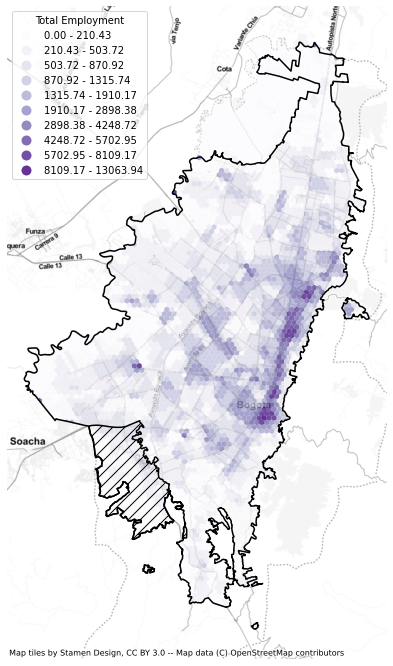

In [39]:
# 1 EMPLOYMENT PLOT 

# When using double square root, notice how it becomes clear how jobs are concentrated at some points and not others
bogota_hex_jobs_projected = bogota_hex_jobs
bogota_hex_jobs_projected['sqrt_jobs'] = np.sqrt(np.sqrt(bogota_hex_jobs_projected['jobs_count']))
bogota_hex_jobs_projected.crs = {'init':'epsg:4326'}
bogota_hex_jobs_projected = bogota_hex_jobs_projected.to_crs(epsg=3857)

# Figure Setup 
fig, ax = plt.subplots(1,1, figsize=(12,12))
#plt.title('Employment Distribution')
plt.axis('off')

# Bogota Boundary
place = {'city': 'Bogota',
         'country':'Colombia'}
bogota_boundary = ox.gdf_from_place(place)
bogota_boundary.crs = {'init':'epsg:4326'}
bogota_boundary = bogota_boundary.to_crs(epsg=3857)
bogota_boundary.boundary.plot(ax = ax, color='k')

# Plot Employment
bogota_hex_jobs_projected.plot(ax = ax, column = 'jobs_count', legend=True, legend_kwds={"loc":'upper left',"title":"Total Employment"}, cmap='Purples', alpha=0.8, scheme='naturalbreaks', k=10)

# Ciudad Bolivar Hatched
neighborhood_boundaries = gpd.read_file(city_data + 'bogota_neighborhood_boundaries.shp')
ciudad_bolivar_full_boundary = neighborhood_boundaries[neighborhood_boundaries['LocNombre'] == 'CIUDAD BOLIVAR']
ciudad_bolivar_full_boundary = ciudad_bolivar_full_boundary.to_crs(epsg=3857)
ciudad_bolivar_boundary = gpd.overlay(ciudad_bolivar_full_boundary, bogota_boundary, how='intersection')
ciudad_bolivar_boundary.plot(ax=ax, hatch="//", color='w', alpha=0)
ciudad_bolivar_boundary.boundary.plot(ax=ax, color='k')

# Add Basemap
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

plt.savefig(run_path + 'plot1_employment.png', dpi=400)


### 2. Bogota Acessibility Total Plot (no gondola data)

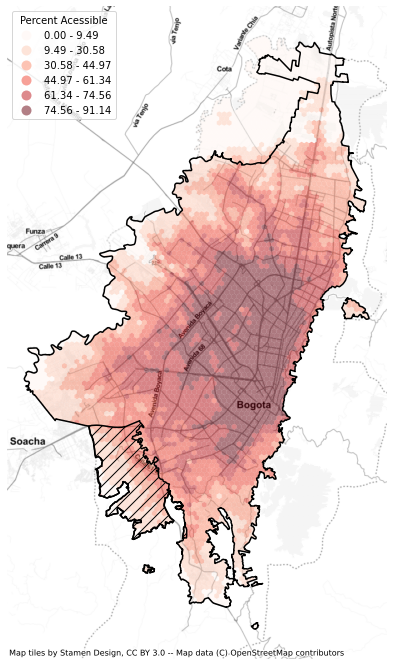

In [101]:
# 2. BOGOTA ACESSIBILITY PLOT

bogota_hex_access_no_gondola_projected = bogota_hex_access_no_gondola
bogota_hex_access_no_gondola_projected.crs = {'init':'epsg:4326'}
bogota_hex_access_no_gondola_projected = bogota_hex_access_no_gondola_projected.to_crs(epsg=3857)

# Plot Axes
fig, ax = plt.subplots(1,1, figsize=(12,12))

# Bogota Boundary
place = {'city': 'Bogota',
         'country':'Colombia'}
bogota_boundary = ox.gdf_from_place(place)
bogota_boundary.crs = {'init':'epsg:4326'}
bogota_boundary = bogota_boundary.to_crs(epsg=3857)
bogota_boundary.boundary.plot(ax = ax, color='k')

# Hexagons
bogota_hex_access_no_gondola_projected['60_percent'] = 100*bogota_hex_access_no_gondola_projected[60]/sum(bogota_hex_jobs['jobs_count'])
bogota_hex_access_no_gondola_projected.plot(ax = ax, column = '60_percent', legend=True, legend_kwds={"loc":'upper left',"title":"Percent Acessible"}, cmap='Reds', alpha=0.5, scheme='quantiles', k=6)
# plt.title('60 Minute Employment Acessibility in Bogota')
plt.axis('off')

# Gondola
# plt.scatter(points_origins['X'], points_origins['Y'], marker='o', s=10)
# plt.title('Acessibility in Ciudad Bolivar')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

# Ciudad Bolivar Label
# ciudad_bolivar_y, ciudad_bolivar_x = 4.546088, -74.153357
# plt.text(ciudad_bolivar_x, ciudad_bolivar_y, 'Ciudad Bolivar', fontsize=10)
# plt.scatter(ciudad_bolivar_x, ciudad_bolivar_y, marker='*', s = 50)

# Ciudad Bolivar Hatched
neighborhood_boundaries = gpd.read_file(city_data + 'bogota_neighborhood_boundaries.shp')
ciudad_bolivar_full_boundary = neighborhood_boundaries[neighborhood_boundaries['LocNombre'] == 'CIUDAD BOLIVAR']
ciudad_bolivar_full_boundary = ciudad_bolivar_full_boundary.to_crs(epsg=3857)
ciudad_bolivar_boundary = gpd.overlay(ciudad_bolivar_full_boundary, bogota_boundary, how='intersection')
ciudad_bolivar_boundary.plot(ax=ax, hatch="//", color='w', alpha=0)
ciudad_bolivar_boundary.boundary.plot(ax=ax, color='k')

# Add Basemap
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

plt.savefig(run_path + 'plot2_bogota_acesss_total.png', dpi=400)



### 3. Bogota Acessibility Change

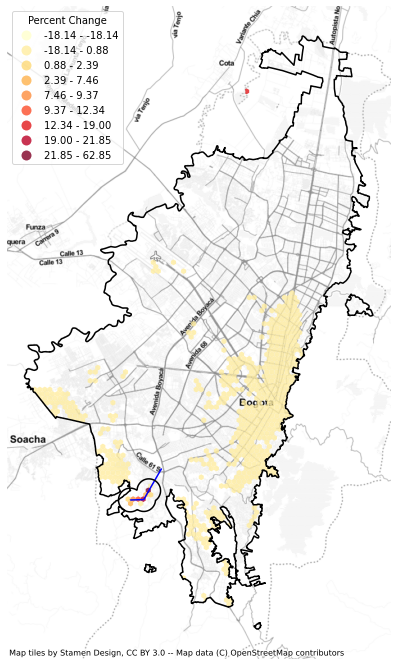

In [102]:
# 3. WHOLE CITY CHANGE PLOT 

# Calculate absolute and percent change
bogota_hex_access_change = bogota_hex_access_no_gondola[['HEXID','geometry']]
bogota_hex_access_change = bogota_hex_access_no_gondola[['HEXID','geometry']]
cols = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).columns
for col in cols :
    # ABSOLUTE TOGGLE
    # bogota_hex_access_change[col] = bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col]
    # PERCENT TOGGLE
    bogota_hex_access_change[col] = 100*(bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col])/bogota_hex_access_no_gondola[col]

    
# Drop all zero valued hexagons  
bogota_hex_access_change = bogota_hex_access_change[bogota_hex_access_change[60] != 0]

# Drop outlier hexagons
#bogota_hex_access_change = bogota_hex_access_change.drop(index=[243,15,4052], axis=0)

# Drop all hexagons outside ciudad bolivar
# xmin,ymin,xmax,ymax = -74.172710, 4.540929, -74.133142, 4.574040
# bogota_hex_access_change = bogota_hex_access_change.cx[xmin:xmax, ymin:ymax]

# Change projection type
bogota_hex_access_change.crs = {'init':'epsg:4326'}
bogota_hex_access_change = bogota_hex_access_change.to_crs(epsg=3857)

# Plot Axes
fig, ax = plt.subplots(1,1, figsize=(12,12))

# Bogota Boundary
place = {'city': 'Bogota',
         'country':'Colombia'}
bogota_boundary = ox.gdf_from_place(place)
bogota_boundary.crs = {'init':'epsg:4326'}
bogota_boundary = bogota_boundary.to_crs(epsg=3857)
bogota_boundary.boundary.plot(ax = ax, color='k')

# Hexagons
bogota_hex_access_change.plot(ax = ax, column = 60, legend=True, legend_kwds={"loc":'upper left',"title":"Percent Change"}, cmap='YlOrRd', alpha=0.8, scheme='naturalbreaks', k=9)      
# plt.title('Percent Change in 60 minute Acessibility in Ciudad Bolivar')
plt.axis('off')

# Zoom into Ciudad Bolivar
# xmin, xmax, ymin, ymax = -8256500, -8252500, 506100, 509500
# ax.set_xlim(xmin,xmax)
# ax.set_ylim(ymin,ymax)

# Gondola new 
# gondola_stations = pd.read_csv('points_origins.csv')
# gondola_stations = gpd.GeoDataFrame(gondola_stations, geometry=gpd.points_from_xy(gondola_stations['X'], gondola_stations['Y']))
# gondola_stations.crs = {'init':'epsg:4326'}
# gondola_stations = gondola_stations.to_crs(epsg=3857)
# gondola_stations.plot(ax=ax, color='r')

# Gondola Names
# for x, y, label in zip(gondola_stations.geometry.x, gondola_stations.geometry.y, gondola_stations['Description']):
#     ax.annotate(label, xy=(x, y), xytext=(0, -15), textcoords="offset points")

# Gondola from SHP file 
gondola_estaciones = gpd.read_file(city_data + 'Estaciones.shp')
gondola_estaciones.crs = {'init':'epsg:4326'}
gondola_estaciones = gondola_estaciones.to_crs(epsg=3857)
gondola_estaciones.plot(ax=ax, color='b')

gondola_line = gpd.read_file(city_data + 'tmc_line.shp')
gondola_line.crs = {'init':'epsg:4326'}
gondola_line = gondola_line.to_crs(epsg=3857)
gondola_line.plot(ax=ax, color='b')
    
# Plot 800 meter buffer around site 
gondola_area = gpd.read_file(city_data + 'cablesarea.geojson')
gondola_area = gondola_area[gondola_area['station_area'] == 'cb']
# gondola_area.crs = {'init':'epsg:4326'}
gondola_area = gondola_area.to_crs(epsg=3857)
gondola_area.boundary.plot(ax=ax, color='k')
    

# OLD Gondola
# plt.scatter(points_origins['X'], points_origins['Y'], marker='o', s=10)
# plt.title('Acessibility in Ciudad Bolivar')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')


# Add Basemap
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

plt.savefig(run_path + 'plot3_bogota_access_change.png', dpi=400)



### 4. Ciudad Bolivar Acessibility Change

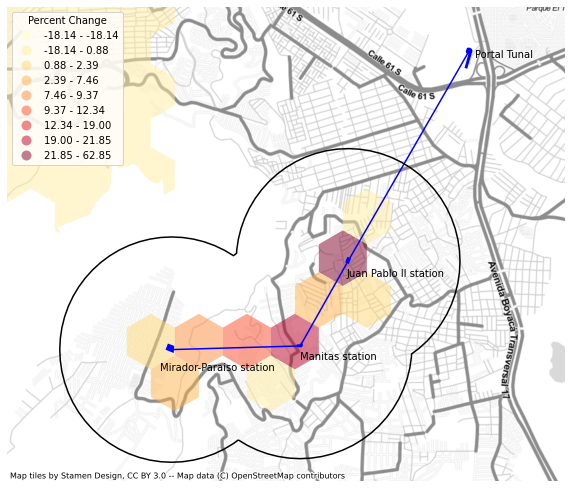

In [103]:
# CIUDAD BOLIVAR PLOT 

# Calculate absolute and percent change
bogota_hex_access_change = bogota_hex_access_no_gondola[['HEXID','geometry']]
bogota_hex_access_change = bogota_hex_access_no_gondola[['HEXID','geometry']]
cols = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).columns
for col in cols :
    # ABSOLUTE TOGGLE
    # bogota_hex_access_change[col] = bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col]
    # PERCENT TOGGLE
    bogota_hex_access_change[col] = 100*(bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col])/bogota_hex_access_no_gondola[col]

    
# Drop all zero valued hexagons  
bogota_hex_access_change = bogota_hex_access_change[bogota_hex_access_change[60] != 0]

# Drop outlier hexagons
# bogota_hex_access_change = bogota_hex_access_change.drop(index=[243,15,4052], axis=0)

# Drop all hexagons outside ciudad bolivar
# xmin,ymin,xmax,ymax = -74.172710, 4.540929, -74.133142, 4.574040
# bogota_hex_access_change = bogota_hex_access_change.cx[xmin:xmax, ymin:ymax]

# Change projection type
bogota_hex_access_change.crs = {'init':'epsg:4326'}
bogota_hex_access_change = bogota_hex_access_change.to_crs(epsg=3857)


# Plot Axes
fig, ax = plt.subplots(1,1, figsize=(10,10))

# Bogota Boundary
# place = {'city': 'Bogota',
#          'country':'Colombia'}
# bogota_boundary = ox.gdf_from_place(place)
# bogota_boundary.crs = {'init':'epsg:4326'}
# bogota_boundary = bogota_boundary.to_crs(epsg=3857)
# bogota_boundary.boundary.plot(ax = ax, color='k')

# Hexagons
bogota_hex_access_change.plot(ax = ax, column = 60, legend=True, legend_kwds={"loc":'upper left','title':'Percent Change'}, cmap='YlOrRd', alpha=0.5, scheme='naturalbreaks', k=9)
# plt.title('Percent Change in 60 minute Acessibility in Ciudad Bolivar')
plt.axis('off')

# Zoom into Ciudad Bolivar
xmin, xmax, ymin, ymax = -8256500, -8252500, 506100, 509500
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

# Gondola Names
gondola_stations = pd.read_csv(city_data + 'gondola_stations.csv')
gondola_stations = gpd.GeoDataFrame(gondola_stations, geometry=gpd.points_from_xy(gondola_stations['X'], gondola_stations['Y']))
gondola_stations.crs = {'init':'epsg:4326'}
gondola_stations = gondola_stations.to_crs(epsg=3857)
for x, y, label in zip(gondola_stations.geometry.x, gondola_stations.geometry.y, gondola_stations['Description']):
    ax.annotate(label, xy=(x, y), xytext=(0, -15), textcoords="offset points")
# gondola_stations.plot(ax=ax, color='r')
    
# Gondola from SHP file 
gondola_estaciones = gpd.read_file(city_data + 'Estaciones.shp')
gondola_estaciones.crs = {'init':'epsg:4326'}
gondola_estaciones = gondola_estaciones.to_crs(epsg=3857)
gondola_estaciones.plot(ax=ax, color='b')

gondola_line = gpd.read_file(city_data + 'tmc_line.shp')
gondola_line.crs = {'init':'epsg:4326'}
gondola_line = gondola_line.to_crs(epsg=3857)
gondola_line.plot(ax=ax, color='b')
    
# Plot 800 meter buffer around site 
gondola_area = gpd.read_file(city_data + 'cablesarea.geojson')
gondola_area = gondola_area[gondola_area['station_area'] == 'cb']
# gondola_area.crs = {'init':'epsg:4326'}
gondola_area = gondola_area.to_crs(epsg=3857)
gondola_area.boundary.plot(ax=ax, color='k')
    

# OLD Gondola
# plt.scatter(points_origins['X'], points_origins['Y'], marker='o', s=10)
# plt.title('Acessibility in Ciudad Bolivar')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')


# Add Basemap
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

plt.savefig(run_path + 'plotr_ciudad_bolivar_access_change.png', dpi=400)



## Conclusion <a class="anchor" id="conclusion"></a>

Remarks on the plots and data analysis across different hexagon sizes can be found in our paper.

In [ ]:
# Plot accessibility at 60 minute mark

times = [10, 30, 50, 70, 90, 110]

fix, axs = plt.subplots(3,2, figsize = (20,30))

for i in range(len(times)) :
    row_spot = math.floor(i/2)
    col_spot = i%2
    bogota_hex_access_no_gondola.plot(ax=axs[row_spot,col_spot], column = times[i], legend=True)
    title = 'Pre-Gondola Acessibility at ' + str(times[i]) + 'min'
    axs[row_spot,col_spot].set_title(title)



In [ ]:
# Plot Change in Accessibility before/after gondola 
# display(bogota_hex_access_no_gondola)
# display(bogota_hex_access_gondola)

bogota_hex_access_change = bogota_hex_access_no_gondola[['HEXID','geometry']]

cols = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).columns

for col in cols :
    bogota_hex_access_change[col] = bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col]
    
times = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

fix, axs = plt.subplots(math.floor(i/2),2, figsize = (20,30))

for i in range(len(times)) :
    row_spot = math.floor(i/2)
    col_spot = i%2
    bogota_hex_access_change.plot(ax=axs[row_spot,col_spot], column = times[i], legend=True)
    title = 'Change in acessibiilty at ' + str(times[i]) + 'min'
    axs[row_spot,col_spot].set_title(title)
    # Ciudad bolivar Boundaries
    xmin,ymin,xmax,ymax = -74.172710, 4.540929, -74.133142, 4.574040
    axs[row_spot,col_spot].set_xlim(xmin,xmax)
    axs[row_spot,col_spot].set_ylim(ymin,ymax)
    
    

In [ ]:
# Plot the graphs for a given points accessability 
# Inputs: 
    # Hexagons with accessitiblities
    # File with points desired to have accessibility calculated at

points = pd.read_csv('points_destinations.csv')

geo_points = gpd.GeoDataFrame(points, geometry=geopandas.points_from_xy(points['X'], points['Y']))

from shapely.ops import nearest_points

points_with_hexid = gpd.sjoin(geo_points, bogota_hex, how='left', op='within')


# hex_points = nearest_points(geo_points.unary_union, bogota_hex_centroid.unary_union)
# print(hex_points)

to_plot = points_with_hexid

columns = 3
rows = math.floor((len(to_plot)/columns))+1
fig, axs = plt.subplots(rows, columns, figsize=(12, 6*rows))
#fig.suptitle('Acessibility at various points (Orange:Gondola, Blue: No Gondola)')

for i in range(len(to_plot)) :  
    no_gon_vals = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).loc[to_plot['HEXID'][i]]
    axs[math.floor(i/columns), i%columns].plot(no_gon_vals.index, no_gon_vals.values, marker='s', label = 'no gondola')

    gon_vals = bogota_hex_access_gondola.drop(columns=['HEXID','geometry']).loc[to_plot['HEXID'][i]]
    axs[math.floor(i/columns), i%columns].plot(gon_vals.index, gon_vals.values, label = 'gondola')
    
    axs[math.floor(i/columns), i%columns].set_title(to_plot['Description'][i])
    axs[math.floor(i/columns), i%columns].set_ylabel('Jobs Accessible')
    axs[math.floor(i/columns), i%columns].set_xlabel('Max Travel Time [min]')




In [ ]:
to_plot = points_with_hexid

fig, ax = plt.subplots(figsize=(15,15))
ax.set_ylabel('Jobs Accessible')
ax.set_xlabel('Max Travel Time [min]')
ax.set_title('No Gondola Baseline Accessibility')

to_plot = points_with_hexid.iloc[0:10]

for i in range(len(to_plot)):
    no_gon_vals = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).loc[to_plot['HEXID'][i]]
    ax.plot(no_gon_vals.index, no_gon_vals.values, marker='s', label = to_plot['Description'][i])

ax.legend()



# +===+===+===+===+===+===+===+===+===+===+===+===+===+===+===+===+===+===+===+===+

# Scratchwork



In [ ]:
# Plot Ciudad bolivar specific Area 
# Plot hexagons showing change (with white/transparent being zero)
# Plot gondola stations, ideally with labels 
# Plot background terrain for context of hexagons 

bogota_hex_access_change = bogota_hex_access_no_gondola[['HEXID','geometry']]
bogota_hex_access_change_percent = bogota_hex_access_no_gondola[['HEXID','geometry']]


cols = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).columns

for col in cols :
    bogota_hex_access_change[col] = bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col]
    bogota_hex_access_change_percent[col] = 100*(bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col])/bogota_hex_access_no_gondola[col]

# Drop all zero valued hexagons to reflect 
bogota_hex_access_change = bogota_hex_access_change[bogota_hex_access_change[60] != 0]

# Ciudad bolivar Boundaries
xmin,ymin,xmax,ymax = -74.172710, 4.540929, -74.133142, 4.574040
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
bogota_hex_access_change = bogota_hex_access_change.cx[xmin:xmax, ymin:ymax]


fig, ax = plt.subplots(1,1, figsize = (10,10))

# Bogota Boundary
place = {'city': 'Bogota',
         'country':'Colombia'}
bogota_boundary = ox.gdf_from_place(place)
bogota_boundary.crs = {'init':'epsg:4326'}
#bogota_boundary = bogota_boundary.to_crs(epsg=3857)
bogota_boundary.boundary.plot(ax = ax, color='k')

# Street Network
# fig, ax = ox.plot_graph(ax=ax, G)

# Hexagons
# bogota_hex_access_change vs. bogota_hex_access_change_percent , can toggle
bogota_hex_access_change_percent.plot(ax=ax, column = 60, legend=True, cmap="Wistia")

ax.plot(points_origins['X'],points_origins['Y'])
# Gondola
for i in range(len(points_origins)) : 
    plt.text(points_origins['X'][i], points_origins['Y'][i]-.0015, points_origins['Description'][i], fontsize= 10)
plt.scatter(points_origins['X'], points_origins['Y'], marker='o', s=100)

plt.title('Acessibility Change in Ciudad Bolivar')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add basemap
#ctx.add_basemap(ax)



In [ ]:
# Find geometries with most and least changed travel times!
geo_travel_times_all[geo_travel_times_all['travel_time_min_gondola'] != geo_travel_times_all['travel_time_min_no_gondola']]['origin'].value_counts()

In [ ]:
fig, axs = plt.subplots(rows, columns, figsize=(12, 6*rows))
#fig.suptitle('Acessibility at various points (Orange:Gondola, Blue: No Gondola)')

for i in range(len(to_plot)) :  
    no_gon_vals = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).loc[to_plot['HEXID'][i]]
    axs[math.floor(i/columns), i%columns].plot(no_gon_vals.index, no_gon_vals.values, marker='s', label = 'no gondola')

    gon_vals = bogota_hex_access_gondola.drop(columns=['HEXID','geometry']).loc[to_plot['HEXID'][i]]
    axs[math.floor(i/columns), i%columns].plot(gon_vals.index, gon_vals.values, label = 'gondola')
    
    axs[math.floor(i/columns), i%columns].set_title(to_plot['Description'][i])
    axs[math.floor(i/columns), i%columns].set_ylabel('Jobs Accessible')
    axs[math.floor(i/columns), i%columns].set_xlabel('Max Travel Time [min]')

### SCRATCHWORK

Website on how to concatenate csv files:

https://stackoverflow.com/questions/44791212/concatenating-multiple-csv-files-into-a-single-csv-with-the-same-header-python#44791486
    